In [1]:
# !pip install joblib
# !pip install threadpoolctl
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, Perceptron, PassiveAggressiveClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, StackingClassifier, BaggingClassifier 
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, CategoricalNB, ComplementNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

from collections import Counter
from scipy.sparse import csr_matrix
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re

# !pip install urlextract
import urlextract
find_urls = urlextract.URLExtract().find_urls

# !pip install empath
from empath import Empath

import nltk
nltk.download('stopwords')
nltk.download('punkt')
stem = nltk.PorterStemmer().stem

path = '/Users/hashem/Python/TDI/capstone/data/'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hashem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hashem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class get_text(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.text

In [ ]:
# to merge two-part texts (text + selftext in submissions)
def merge_text(t1, t2):
    if isinstance(type(t1), str) and t1!='[removed]':
        if isinstance(type(t2),str) and t2!='[removed]':
            text = t1+' '+t2
        else:
            text = t1
    elif isinstance(type(t2),str) and t2 != '[removed]':
        text = t2
    else:
        text = ''
    return text

In [2]:
# make texts lower-case
class lower_case(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [x.lower() for x in X]

In [3]:
# replace all urls with 'URL'
class replace_urls(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        for text in X:
            urls = list(set(find_urls(text)))
            urls.sort(key=lambda x: len(x), reverse=True)
            for url in urls:
                text = text.replace(url, 'URL')
            X_transformed.append(text)

        return X_transformed

In [4]:
# replace all numbers with 'NUM'
class replace_numbers(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for text in X:
            text_tr = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUM', text)
            X_transformed.append(text_tr)

        return X_transformed

In [4]:
# limit size of the text
class limit_size(BaseEstimator, TransformerMixin):
    def __init__(self, size):
        self.size = size

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        index = [len(text) < self.size for text in X['text']]
        return X[index]

In [5]:
# remove punctuations
class remove_punctuation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for text in X:
            text_tr = re.sub(r'\W+', ' ', text, flags=re.M)
            X_transformed.append(text_tr)

        return X_transformed

In [6]:
# remove key words
class remove_key_words(BaseEstimator, TransformerMixin):
    def __init__(self, remove_list):
        self.remove_list = remove_list

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        for text in X:
            for word in self.remove_list:
                text = text.replace(word, '')
            X_transformed.append(text)

        return X_transformed

In [7]:
# remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
class remove_stopwords(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords=stopwords):
        self.stopwords = stopwords

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for text in X:
            text_=''
            for word in nltk.tokenize.word_tokenize(text):
                if word not in self.stopwords:
                    text_ = ' '.join([text_,word])
            X_transformed.append(text_)

        return X_transformed

In [8]:
# counting the number of words in a text
class wordCount(BaseEstimator, TransformerMixin):
    def __init__(self, stemming=True):
        self.stemming = stemming

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        for text in X:
            word_counts = Counter(text.split())
            
            if self.stemming:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
                
            X_transformed.append(word_counts)
            
        return X_transformed

In [9]:
# transfering words to vectors
class toVector(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=10000):
        self.vocabulary_size = vocabulary_size
        
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                # total_count[word] += count
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        csr = csr_matrix((data, (rows, cols)), shape=(len(X), len(self.vocabulary_) + 1))
        return csr

In [2]:
class empath(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        empath = []
        for text in X:
            empath.append(Empath().analyze(text, normalize=True))
        return empath

In [3]:
groups = {'control':['AskReddit_1.csv', 'AskReddit2_1.csv'],
          'ocd':['OCD_1.csv','OCPD_1.csv'],
          'autism':['AutisticAdults_1.csv', 'autism_1.csv', 'asperger_1.csv', 'AutismInWomen_1.csv'],
          'depression':['sad_1.csv', 'depression_1.csv'],
          'adhd':['ADHD_1.csv', 'ADHD2_1.csv'],
          'borderline':['Borderline_1.csv'],
          'socialanxiety':['socialanxiety2_1.csv', 'socialanxiety_1.csv'],
          'phobia':['emetophobia_1.csv', 'Agoraphobia_1.csv', 'Phobia_1.csv'],
          'general':['mentalillness_1.csv', 'personalitydisorders_1.csv', 'mental_1.csv', 'MentalHealthPH_1.csv'],
          'avoidant':['Avoidant_1.csv'],
          'aspd':['aspd_1.csv','psychopath_1.csv'],
          'narcissism':['narcissism_1.csv'],
          'schizophrenia':['schizoaffective_1.csv', 'paranoidschizophrenia_1.csv', 'Psychosis_1.csv', 
                           'schizophrenia_1.csv', 'Paranoid_1.csv'],
          'anger':['Anger_1.csv'],
          'body':['DysmorphicDisorder_1.csv', 'BodyAcceptance_1.csv'],
          'addiction':['addiction_1.csv', 'alcoholism_1.csv'],
          'schizoid':['Schizoid_1.csv', 'Schizotypal_1.csv'],
          'eating':['EatingDisorders_1.csv', 'bulimia_1.csv'],
          'bipolar':['bipolar_1.csv'],
          'ptsd':['ptsd_1.csv', 'CPTSD_1.csv'],
          'selfhard':['selfharm_1.csv', 'SuicideWatch_1.csv']}

['Tourettes_1.csv',
 'AskReddit_1.csv',
 'OCD_1.csv',
 'emetophobia_1.csv',
 'AutisticAdults_1.csv',
 'mentalillness_1.csv',
 'autism_1.csv',
 'sad_1.csv',
 'BodyAcceptance_1.csv',
 'ADHD_1.csv',
 'Borderline_1.csv',
 'Avoidant_1.csv',
 'asperger_1.csv',
 'aspd_1.csv',
 'hpd_1.csv',
 'OCPD_1.csv',
 'ADHD2_1.csv',
 'narcissism_1.csv',
 'Anger_1.csv',
 'selfharm_1.csv',
 'schizoaffective_1.csv',
 'Agoraphobia_1.csv',
 'Psychopathy_1.csv',
 'dpdr_1.csv',
 'depression_1.csv',
 'AutismInWomen_1.csv',
 'Paranoid_1.csv',
 'ptsd_1.csv',
 'schizophrenia_1.csv',
 'MentalHealthPH_1.csv',
 'SuicideWatch_1.csv',
 'alcoholism_1.csv',
 'Schizotypal_1.csv',
 'bulimia_1.csv',
 'bipolar_1.csv',
 'socialanxiety_1.csv',
 'socialanxiety2_1.csv',
 'EatingDisorders_1.csv',
 'psychopath_1.csv',
 'mental_1.csv',
 'Psychosis_1.csv',
 'Schizoid_1.csv',
 'personalitydisorders_1.csv',
 'Phobia_1.csv',
 'AskReddit2_1.csv',
 'CPTSD_1.csv',
 'addiction_1.csv',
 'DysmorphicDisorder_1.csv',
 'paranoidschizophrenia_1.cs

In [12]:
len(groups)

21

In [4]:
# get X, y
X=[]
y=[]
for key,gs in groups.items():
    for g in gs:
        df = pd.read_csv('data/'+g, usecols=['text'], lineterminator='\n')
        X.extend(df.text)
        y.extend([key]*len(df))

In [5]:
data = [(x,y) for x,y in zip(X,y)]

In [39]:
limit = 200

data_limited = [(x,y) for x,y in data if len(x)>limit]
X_limited = [x for x,y in data_limited]
y_limited = [y for x,y in data_limited]

vec = TfidfVectorizer(min_df=10)
X_tr = vec.fit_transform(X_limited)
X_train, X_test, y_train, y_test = train_test_split(X_tr,y_limited)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('sample size: ', len(y_limited))
print('Accuracy: {:.2f}%\n'.format(100*accuracy_score(y_test, y_pred)))
print('Precision (micro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='micro'))) 
print('Recall (micro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='micro')))  
print('F1 (micro): {:.2f}%\n'.format(100*f1_score(y_test, y_pred, average='micro'))) 
print('Precision (macro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='macro'))) 
print('Recall (macro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='macro'))) 
print('F1 (macro): {:.2f}%'.format(100*f1_score(y_test, y_pred, average='macro')))   

sample size:  1161324
Accuracy: 20.35%

Precision (micro): 20.35%
Recall (micro): 20.35%
F1 (micro): 20.35%

Precision (macro): 50.03%
Recall (macro): 13.29%
F1 (macro): 14.23%


In [42]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import re

def process_review(review):
    """
    Splits review into sentences, then sentences into tokens. Returns 
    nested list.
    """
    words = [simple_preprocess(sentence, deacc=True) 
             for sentence in re.split('\.|\?|\!', review)
             if sentence]
    return words

limit = 200

data_limited = [(x,y) for x,y in data if len(x)>limit]
X_limited = [x for x,y in data_limited]
y_limited = [y for x,y in data_limited]

# Flatten list to contain all sentences from all reviews
sentences = [sentence for review in X_limited 
             for sentence in process_review(review)]

In [43]:
len(sentences)

8330686

In [62]:
token_sizes = [len(x.split()) for x in X_limited]

(array([1.157667e+06, 3.126000e+03, 3.680000e+02, 9.700000e+01,
        3.100000e+01, 2.000000e+01, 9.000000e+00, 4.000000e+00,
        0.000000e+00, 2.000000e+00]),
 array([1.0000e+00, 9.1590e+02, 1.8308e+03, 2.7457e+03, 3.6606e+03,
        4.5755e+03, 5.4904e+03, 6.4053e+03, 7.3202e+03, 8.2351e+03,
        9.1500e+03]),
 <BarContainer object of 10 artists>)

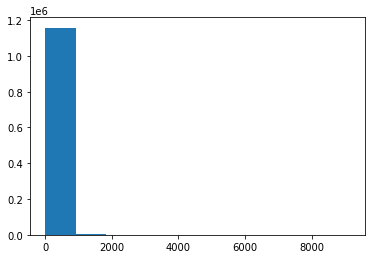

In [65]:
import matplotlib.pyplot as plt
plt.hist(token_sizes, 10)

In [68]:
from scipy.stats import gaussian_kde
kde = gaussian_kde(token_sizes)


In [ ]:
x=np.arange(0,1000)
y= kde.evaluate(x)
plt.plot(x,y)

In [ ]:
kde.evaluate(token_sizes)

In [49]:
w2v = Word2Vec(sentences,
               workers=3,   # Worker threads (=faster w/ multicore)
               vector_size=400,    # Dimensionality of word vectors
               window=11,    # Window size
               min_count=10, # Ignore words with frequency lower than this
               sample=1e-3) # Threshold for which higher-frequency 
                            # words are randomly downsampled

w2v.save('w2v.model')

In [9]:
limit=200
data_limited = [(x,y) for x,y in data if len(x)>limit]
X_limited = [x for x,y in data_limited]
y_limited = [y for x,y in data_limited]

In [6]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
w2v = Word2Vec.load('w2v.model')

In [ ]:
def vectorize(data, maxlen=500, embedding_dim=400):
    """
    Tokenizes reviews, truncates the number of tokens if more than `maxlen`, 
    and vectorizes each token. Returns a three-dimensional array of shape
    n reviews x `maxlen` x `embedding_dim`. 
    """
    # Create empty array
    vectorized_data = np.zeros(shape=(len(data), maxlen, embedding_dim))
    
    for row, case in enumerate(data):
        # Preprocess each review
        tokens = simple_preprocess(case)
        
        # Truncate long reviews
        if len(tokens) > maxlen:
            tokens = tokens[:maxlen]
        
        # Get vector for each token in review
        for col, token in enumerate(tokens):
            try:
                word_vector = w2v.wv[token]
                # Add vector to array
                vectorized_data[row, col] = word_vector[:embedding_dim]
            except KeyError:
                pass
    
    return vectorized_data

maxlen = 500        # Our predetermined limit
embedding_dim = 400 # The first 100 values in our w2v vectors

X = vectorize(X_limited, maxlen, embedding_dim)
y = np.array(y_limited).reshape(-1,1)

print('Shape of feature matrix:', X.shape)
print('Shape of target vector:', y.shape)

In [ ]:
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
            
gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(maxlen, embedding_dim)),
    Dropout(0.25),
    GRU(64),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

print(gru_model.summary())

In [38]:
pipe = Pipeline([('lower', lower_case()),
                 ('url', replace_urls()),
                 ('num', replace_numbers()),
                 ('punc', remove_punctuation()),
                 ('stop', remove_stopwords()),
                 ('count', wordCount()),
                 ('vec', toVector())])
X_tr = pipe.fit_transform(X_100)

In [40]:
import pickle
with open('transformed_bag.pkl', 'wb') as f:
    pickle.dump(X_tr, f)
    pickle.dump(y_100, f)

In [13]:
import pickle
with open('transformed_bag.pkl', 'rb') as f:
    X_tr_ = pickle.load(f)
    y_100_ = pickle.load(f)

In [17]:
len(y_100_), X_tr_.shape

(2286592, (2286592, 10001))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_tr_,y_100_)

In [21]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((1714944, 10001), (571648, 10001), 1714944, 571648)

In [23]:
clf = MultinomialNB()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print('Accuracy: {:.2f}%\n'.format(100*accuracy_score(y_test, y_pred)))
print('Precision (micro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='micro'))) 
print('Recall (micro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='micro')))  
print('F1 (micro): {:.2f}%\n'.format(100*f1_score(y_test, y_pred, average='micro'))) 
print('Precision (macro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='macro'))) 
print('Recall (macro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='macro'))) 
print('F1 (macro): {:.2f}%'.format(100*f1_score(y_test, y_pred, average='macro')))   

Accuracy: 15.23%

Precision (micro): 15.23%
Recall (micro): 15.23%
F1 (micro): 15.23%

Precision (macro): 14.55%
Recall (macro): 13.98%
F1 (macro): 13.70%


In [35]:
print('Accuracy: {:.2f}%\n'.format(100*accuracy_score(y_test, y_pred)))
print('Precision (micro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='micro'))) 
print('Recall (micro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='micro')))  
print('F1 (micro): {:.2f}%\n'.format(100*f1_score(y_test, y_pred, average='micro'))) 
print('Precision (macro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='macro'))) 
print('Recall (macro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='macro'))) 
print('F1 (macro): {:.2f}%'.format(100*f1_score(y_test, y_pred, average='macro')))   

Accuracy: 19.15%

Precision (micro): 19.15%
Recall (micro): 19.15%
F1 (micro): 19.15%

Precision (macro): 31.28%
Recall (macro): 13.69%
F1 (macro): 14.52%


In [36]:
by_chance = 1/len(groups) * 100
print('classifying by chance would result in {:.2f}\% accuracy.\nSo comparing to that, the model is doing a good job?!'.format(by_chance))
      
      

classifying by chance would result in 4.76\% accuracy.
So comparing to that, the model is doing a good job?!


In [ ]:
clf = LogisticRegression()
clf.fit(X_train_tr,y_train)
y_pred = clf.predict(X_test_tr)
print('Accuracy: {:.2f}%\n'.format(100*accuracy_score(y_test, y_pred)))
print('Precision (micro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='micro'))) 
print('Recall (micro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='micro')))  
print('F1 (micro): {:.2f}%\n'.format(100*f1_score(y_test, y_pred, average='micro'))) 
print('Precision (macro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='macro'))) 
print('Recall (macro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='macro'))) 
print('F1 (macro): {:.2f}%'.format(100*f1_score(y_test, y_pred, average='macro')))   

In [37]:
clf = GradientBoostingClassifier()
clf.fit(X_train_tr,y_train)
y_pred = clf.predict(X_test_tr)
print('Accuracy: {:.2f}%\n'.format(100*accuracy_score(y_test, y_pred)))
print('Precision (micro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='micro'))) 
print('Recall (micro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='micro')))  
print('F1 (micro): {:.2f}%\n'.format(100*f1_score(y_test, y_pred, average='micro'))) 
print('Precision (macro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='macro'))) 
print('Recall (macro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='macro'))) 
print('F1 (macro): {:.2f}%'.format(100*f1_score(y_test, y_pred, average='macro')))   

KeyboardInterrupt: 

In [ ]:
clf = MLPClassifier()
clf.fit(X_train_tr,y_train)
y_pred = clf.predict(X_test_tr)
print('Accuracy: {:.2f}%\n'.format(100*accuracy_score(y_test, y_pred)))
print('Precision (micro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='micro'))) 
print('Recall (micro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='micro')))  
print('F1 (micro): {:.2f}%\n'.format(100*f1_score(y_test, y_pred, average='micro'))) 
print('Precision (macro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='macro'))) 
print('Recall (macro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='macro'))) 
print('F1 (macro): {:.2f}%'.format(100*f1_score(y_test, y_pred, average='macro')))   

In [ ]:
clf = RandomforestClassifier()
clf.fit(X_train_tr,y_train)
y_pred = clf.predict(X_test_tr)
print('Accuracy: {:.2f}%\n'.format(100*accuracy_score(y_test, y_pred)))
print('Precision (micro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='micro'))) 
print('Recall (micro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='micro')))  
print('F1 (micro): {:.2f}%\n'.format(100*f1_score(y_test, y_pred, average='micro'))) 
print('Precision (macro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='macro'))) 
print('Recall (macro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='macro'))) 
print('F1 (macro): {:.2f}%'.format(100*f1_score(y_test, y_pred, average='macro')))   

In [ ]:
clf = StackingClassifier(estimators=[('forest',  RandomforestClassifier()),
                                     ('gboost',  HistGradientBoostingClassifier()),
                                     ('MLP',     MLPClassifier()),
                                     ('passAgg', PassiveAggressiveClassifier())],
                         final_estimator=Ridge()

clf.fit(X_train_tr,y_train)
y_pred = clf.predict(X_test_tr)
print('Accuracy: {:.2f}%\n'.format(100*accuracy_score(y_test, y_pred)))
print('Precision (micro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='micro'))) 
print('Recall (micro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='micro')))  
print('F1 (micro): {:.2f}%\n'.format(100*f1_score(y_test, y_pred, average='micro'))) 
print('Precision (macro): {:.2f}%'.format(100*precision_score(y_test, y_pred, average='macro'))) 
print('Recall (macro): {:.2f}%'.format(100*recall_score(y_test, y_pred, average='macro'))) 
print('F1 (macro): {:.2f}%'.format(100*f1_score(y_test, y_pred, average='macro')))   